In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.optimize as spo
import scipy.signal as sps
from pathlib import Path

from spectrometer import FID1D

In [114]:
# Define ETH colors
eth_colors = [
    "#215CAF",  # ETH blue
    "#B7352D",  # ETH red
    "#627313",  # ETH green
    "#A7117A",  # ETH purple
    "#8E6713",  # ETH bronze
    "#007894",  # ETH petrol
    "#6F6F6F",  # ETH gray
]

In [115]:
# Load raw *.fid data
file = Path("../data/20230719-160040-Water_1H_andrew_probe_9us_pulse_25us_delay.fid")
fid = FID1D.from_file(file)

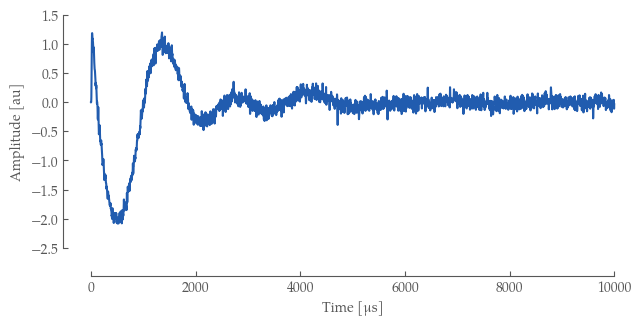

In [128]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plt.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    layout="constrained",
)
axes.plot(fid.us_scale, fid.data.real, color=eth_colors[0])
axes.set_ylabel("Amplitude [au]")
axes.set_xlabel("Time [μs]")

# Adjust axis
axes.spines[["top", "right"]].set_visible(False)
axes.spines[["left", "bottom"]].set_position(("outward", 20))
plt.rcParams["axes.autolimit_mode"] = "round_numbers"
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["axes.ymargin"] = 0
plt.setp(
    [
        *axes.lines,
        *axes.tables,
        *axes.artists,
        *axes.images,
        *axes.patches,
        *axes.texts,
        *axes.collections,
    ],
    clip_on=False,
)

# Set axis colour to ETH Grey
color = "#575757"  # normal grey: "#6F6F6F", dark grey: "#575757"
axes.tick_params(colors=color)
axes.spines[["left", "bottom", "top", "right"]].set_color(color)
axes.xaxis.label.set_color(color)
axes.yaxis.label.set_color(color)

# Change font
plt.setp(
    [
        axes.title,
        axes.xaxis.label,
        axes.yaxis.label,
        *axes.get_xticklabels(),
        *axes.get_yticklabels(),
        *(axes.get_legend().get_texts() if axes.get_legend() else ()),
    ],
    family=["Tex Gyre Pagella"],
)

# Adjust ticks
axes.tick_params(axis="both", direction="in")

fig.savefig("fid_raw.pdf")

In [118]:
def fit_decay(x: npt.NDArray, y: npt.NDArray) -> dict:
    """Fit a decay exponential to the input sequence

    f(x) = amplitude * e^(-lambda*t) + offset

    Returns:
        Fitting parameters "amplitude", "lambda", "offset" and the resulting "function"
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    def decay(t, amplitude, lambda_, offset):
        return amplitude * np.exp(-lambda_ * t) + offset

    # Guess initial fitting parameters
    guess_amplitude = np.max(y) - np.min(y)
    guess_offset = np.min(y)
    guess_lambda = 0
    guess = (guess_amplitude, guess_lambda, guess_offset)

    popt, _pcov = spo.curve_fit(decay, x, y, p0=guess)
    return {
        "amplitude": popt[0],
        "lambda": popt[1],
        "offset": popt[2],
        "function": lambda t: decay(t, *popt),
    }

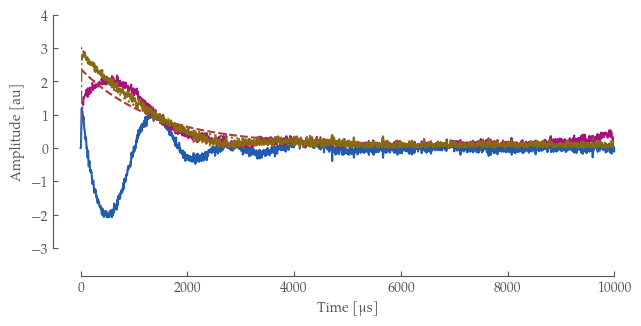

In [119]:
# Try to plot simple least squares fit
# Try fitting the envelope
envelope = np.abs(sps.hilbert(fid.data.real))
axes.plot(fid.us_scale, envelope, linestyle="-.", color=eth_colors[3])
fit_env = fit_decay(fid.us_scale, envelope)
us_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    us_scale_fine,
    fit_env["function"](us_scale_fine),
    linestyle="--",
    color=eth_colors[1],
)

# Try fitting the absolute directly
fit_abs = fit_decay(fid.us_scale, np.abs(fid.data))
axes.plot(fid.us_scale, np.abs(fid.data), linestyle="-.", color=eth_colors[4])
axes.plot(
    us_scale_fine,
    fit_abs["function"](us_scale_fine),
    linestyle=":",
    color=eth_colors[2],
)
axes.set_ylabel("Amplitude [au]")
axes.set_xlabel("Time [μs]")

fig.savefig("fid_fit.pdf")
fig